In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 10)
!date

%load_ext autoreload
%autoreload 2

Mon Jun 17 17:27:24 PDT 2019


# Consistent models in DisMod-MR from Vivarium artifact draw

Take i, r, f, p from a Vivarium artifact, and make a consistent version of them.  See how it compares to the original.

In [2]:
np.random.seed(123456)

In [3]:
import dismod_mr

In [4]:
import vivarium_public_health

# Consistent fit with all data

Let's start with a consistent fit of the simulated PD data.  This includes data on prevalence, incidence, and SMR, and the assumption that remission rate is zero.  All together this counts as four different data types in the DisMod-II accounting.

In [5]:
from vivarium_public_health.dataset_manager import Artifact
art = Artifact('/share/costeffectiveness/artifacts/obesity/obesity.hdf')

In [6]:
art.keys

[EntityKey(metadata.keyspace),
 EntityKey(metadata.versions),
 EntityKey(metadata.locations),
 EntityKey(population.demographic_dimensions),
 EntityKey(population.structure),
 EntityKey(cause.all_causes.cause_specific_mortality),
 EntityKey(population.theoretical_minimum_risk_life_expectancy),
 EntityKey(cause.ischemic_heart_disease.restrictions),
 EntityKey(cause.ischemic_stroke.restrictions),
 EntityKey(cause.diabetes_mellitus_type_2.restrictions),
 EntityKey(cause.asthma.restrictions),
 EntityKey(cause.gout.restrictions),
 EntityKey(cause.osteoarthritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_hypertension.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_glomerulonephritis.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_other_and_unspecified_causes.restrictions),
 EntityKey(cause.chronic_kidney_disease_due_to_diabetes_mellitus_type_2.restrictions),
 EntityKey(risk_factor.high_body_mass_index_in_adults.exposure),
 EntityKey(risk_factor.

In [7]:
def format_for_dismod(df, data_type):
    df = df.query('draw==0 and sex=="Female" and year_start==2017').copy()
    df['data_type'] = data_type
    df['area'] = 'all'
    df['standard_error'] = 0.001
    df['upper_ci'] = np.nan
    df['lower_ci'] = np.nan
    df['effective_sample_size'] = 10_000

    df['sex'] = 'total'
    df = df.rename({'age_group_start': 'age_start',
                                     'age_group_end': 'age_end',}, axis=1)
    return df

p = format_for_dismod(art.load('cause.ischemic_heart_disease.prevalence'), 'p')

In [8]:
i = format_for_dismod(art.load('cause.ischemic_heart_disease.incidence'), 'i')

In [9]:
f = format_for_dismod(art.load('cause.ischemic_heart_disease.excess_mortality'), 'f')

In [10]:
m_all = format_for_dismod(art.load('cause.all_causes.cause_specific_mortality'), 'm_all')

In [11]:
csmr = format_for_dismod(art.load('cause.ischemic_heart_disease.cause_specific_mortality'), 'csmr') # could also try 'pf'

In [12]:
dm = dismod_mr.data.ModelData()
dm.input_data = pd.concat([p, i, f, m_all,
                          csmr
                          ], ignore_index=True)
for rate_type in 'ifr':
    dm.set_knots(rate_type, [0,40,60,80,90,100])

dm.set_level_value('i', age_before=30, age_after=101)
dm.set_increasing('i', age_start=50, age_end=100)

dm.set_level_value('p', value=0, age_before=30, age_after=101)

dm.set_level_value('r', value=0, age_before=100, age_after=101)
# d.hierarchy, d.output_template = data_simulation.small_output()


In [13]:
dm.input_data.data_type.value_counts()

csmr     23
m_all    23
f        23
p        23
i        23
Name: data_type, dtype: int64

In [14]:
dm.setup_model(rate_model='normal', )

/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/share/code/

In [15]:
import pymc as pm
m = pm.MAP(dm.vars)

In [16]:
%%time
m.fit(verbose=1)

Current log-probability : 206.399882
Current log-probability : 211.224348
Current log-probability : 212.087558
Current log-probability : 212.436431
Current log-probability : 212.590606
Current log-probability : 212.706677
Current log-probability : 212.778391
Current log-probability : 212.829294
Current log-probability : 212.863160
Current log-probability : 212.916571
Current log-probability : 212.949182
Current log-probability : 212.969014
Optimization terminated successfully.
         Current function value: -212.969014
         Iterations: 12
         Function evaluations: 16795
CPU times: user 42 s, sys: 156 ms, total: 42.1 s
Wall time: 42.2 s


In [17]:
from IPython.core.pylabtools import figsize
figsize(11, 5.5)

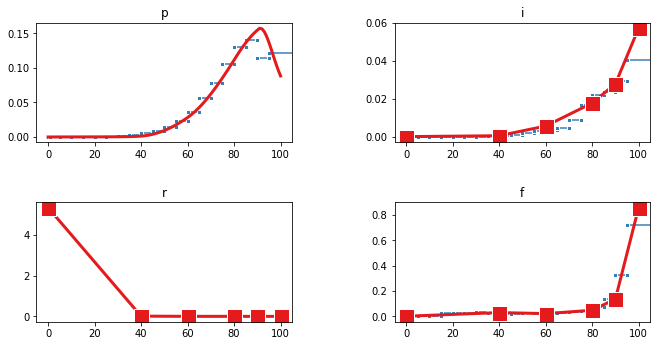

In [18]:
dm.plot()

In [19]:
!date

Mon Jun 17 17:29:08 PDT 2019
